In [1]:
import numpy as np
from movement.io import load_poses
import matplotlib.pyplot as plt
import json
from scipy.signal import welch
from movement import sample_data
from movement.filtering import filter_by_confidence, interpolate_over_time
from movement.kinematics import compute_velocity
from movement.filtering import (
    interpolate_over_time,
    rolling_filter,
    savgol_filter,
)
import xarray as xr
from movement.kinematics import (
    compute_forward_vector,
    compute_forward_vector_angle,
)
from movement.plots import plot_centroid_trajectory
from movement.utils.vector import cart2pol, pol2cart
import os
import glob
import pandas as pd
from scipy.stats import circmean
from scipy.interpolate import interp1d



%matplotlib widget

SHA256 hash of downloaded file: cf2876bab4f754d48d3c9f113ce5ac91787304cc587d33d8bf1124d5358e957f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [2]:

def plot_polar_histogram(arr, bin_width_deg=15, ax=None):
    """
    Plot a polar histogram (rose plot) of angle data in radians.

    Parameters
    ----------
    arr : array-like
        Array of angles in radians.
    bin_width_deg : int, optional
        Width of histogram bins in degrees (default is 15).
    ax : matplotlib.axes._subplots.PolarAxesSubplot, optional
        Axes on which to plot. If None, creates a new one.
    """
    arr = np.asarray(arr)
    arr = arr[~np.isnan(arr)]  # Remove NaNs

    n_bins = int(360 / bin_width_deg)
    bins = np.linspace(-np.pi, np.pi, n_bins + 1)

    # Compute histogram
    counts, bin_edges = np.histogram(arr, bins=bins, density=True)

    # Compute bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Create polar axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "polar"})
    else:
        fig = ax.figure

    # Plot histogram as a bar plot on polar axes
    bars = ax.bar(bin_centers, counts, width=np.diff(bin_edges), align='center', edgecolor='k')

    # Format the plot
    ax.set_theta_direction(-1)
    ax.set_theta_offset(0)
    ax.set_xlabel("")

    # Set xticks
    n_xtick_edges = 9
    ax.set_xticks(np.linspace(0, 2 * np.pi, n_xtick_edges)[:-1])
    xticks_in_deg = (
        list(range(0, 180 + 45, 45)) + list(range(0, -180, -45))[-1:0:-1]
    )
    ax.set_xticklabels([str(t) + "\N{DEGREE SIGN}" for t in xticks_in_deg])

    return ax


In [3]:
def interpolate_circular_deg(hd_array, max_gap=60):
    hd_array = np.asarray(hd_array)
    result = hd_array.copy()
    
    valid = ~np.isnan(hd_array)
    
    if valid.sum() < 2:
        return result

    # Interpolators for sin and cos
    radians = np.deg2rad(hd_array[valid])
    x_valid = np.flatnonzero(valid)

    sin_interp = interp1d(x_valid, np.sin(radians), kind='linear', fill_value="extrapolate")
    cos_interp = interp1d(x_valid, np.cos(radians), kind='linear', fill_value="extrapolate")

    # Identify NaN gaps
    isnan = np.isnan(hd_array)
    gap_start = None

    for i in range(len(hd_array)):
        if isnan[i] and gap_start is None:
            gap_start = i
        elif not isnan[i] and gap_start is not None:
            gap_end = i
            gap_len = gap_end - gap_start

            if gap_len <= max_gap:
                interp_indices = np.arange(gap_start, gap_end)
                interp_sin = sin_interp(interp_indices)
                interp_cos = cos_interp(interp_indices)
                interp_angles_rad = np.arctan2(interp_sin, interp_cos)
                interp_angles_deg = np.rad2deg(interp_angles_rad)
                interp_angles_deg = ((interp_angles_deg + 180) % 360) - 180
                result[interp_indices] = interp_angles_deg

            gap_start = None

    return result

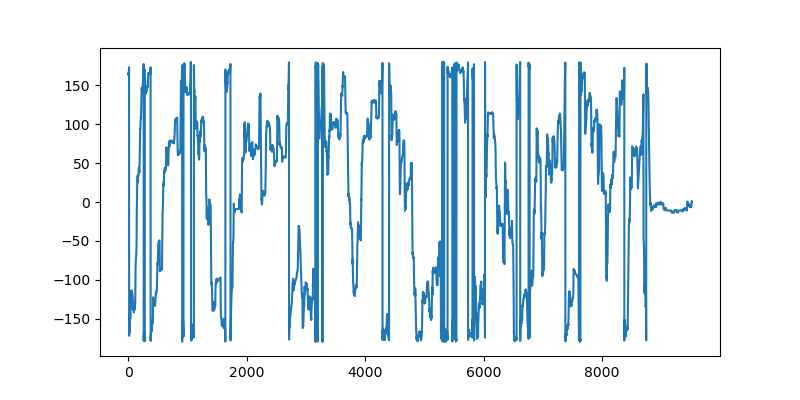

D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\spatial_behav_data\hd_over_time\hd_over_time_t2.png


In [4]:

behav_data_path = r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\spatial_behav_data"
base_path = os.path.join(behav_data_path, 'XY_and_HD')
tr = 2

#df_path = os.path.join(base_path, 'three_hd_methods', f"XY_HD_t{tr}.csv")
df_path = os.path.join(base_path, f"XY_HD_t{tr}_full.csv")
df = pd.read_csv(df_path)

hd_forward = df['hd_forward']
hd_cap_to_ears = df['hd_cap_to_ears']

hd_avg_vals = []

hd_avg_vals = [
    circmean([f, c], high=180, low=-180) if not np.isnan(f) and not np.isnan(c)
    else f if not np.isnan(f)
    else c if not np.isnan(c)
    else np.nan
    for f, c in zip(hd_forward, hd_cap_to_ears)
]

#hd_avg_vals = hd_avg_vals[:8622]
x = np.arange(1, len(hd_avg_vals) + 1)

output_folder = os.path.join(behav_data_path, "hd_over_time")
output_path = os.path.join(output_folder, f"hd_over_time_t{tr}.png")
plt.figure(figsize = [8,4])
plt.plot(x, hd_avg_vals)
plt.show()
#plt.savefig(output_path)
print(output_path)


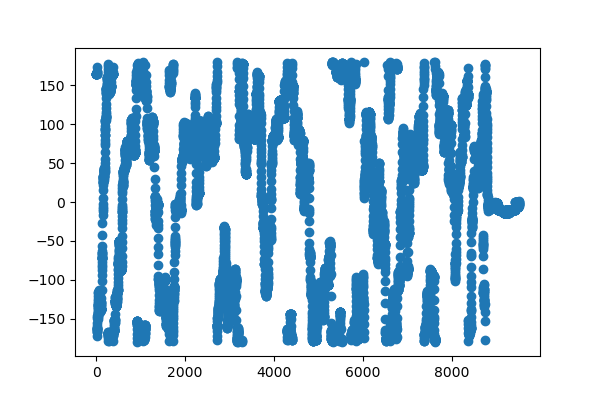

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(x, hd_avg_vals)
plt.show()

In [6]:
last_val = 0
for i in range(len(hd_avg_vals)):
    if not np.isnan(hd_avg_vals[i]):
        last_val = i
print(f"Last value: {last_val}, total_length: {len(hd_avg_vals)}")

hd_avg_vals = hd_avg_vals[:last_val]
new_x = df['x']
new_x = new_x[:last_val]
new_y = df['y'][:last_val]
new_df = pd.DataFrame({'x': new_x, 'y': new_y, 'hd': hd_avg_vals})



Last value: 9513, total_length: 9529


In [7]:
n_nans = np.isnan(hd_avg_vals).sum()
print(f"Number of NaNs: {n_nans}")

if n_nans > 0:  
    output_path = os.path.join(base_path, f'XY_HD_t{tr}_uninterpolated.csv')
else:
    output_path = os.path.join(base_path, f'XY_HD_t{tr}.csv')
#new_df.to_csv(output_path, index = False)
print(output_path)


Number of NaNs: 0
D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\spatial_behav_data\XY_and_HD\XY_HD_t2.csv


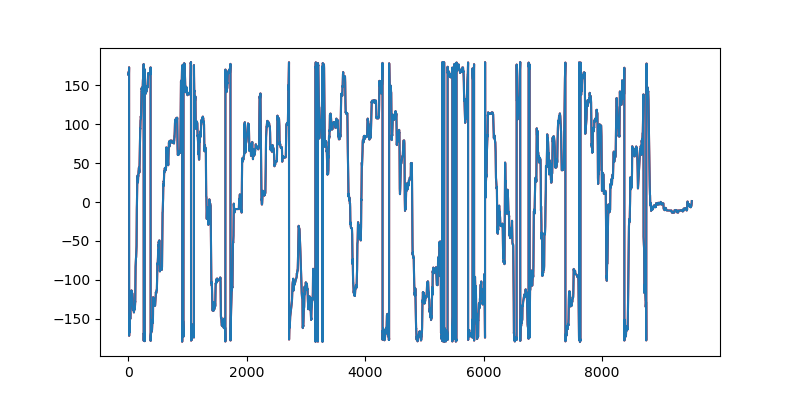

D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\spatial_behav_data\hd_over_time\hd_after_interpolation_t2.png
D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\spatial_behav_data\XY_and_HD\XY_HD_t2.csv


In [8]:
hd_new = interpolate_circular_deg(hd_avg_vals)

x = np.arange(1, len(hd_avg_vals) + 1)

output_folder = os.path.join(behav_data_path, "hd_over_time")
output_path = os.path.join(output_folder, f"hd_after_interpolation_t{tr}.png")
plt.figure(figsize = [8,4])
plt.plot(x, hd_new, c = 'r')
plt.plot(x, hd_avg_vals)
plt.show()
#plt.savefig(output_path)
print(output_path)


new_x = df['x']
new_x = new_x[:last_val]
new_y = df['y'][:last_val]
new_df = pd.DataFrame({'x': new_x, 'y': new_y, 'hd': hd_new})

output_path = os.path.join(base_path, f'XY_HD_t{tr}.csv')
#new_df.to_csv(output_path, index = False)
print(output_path)

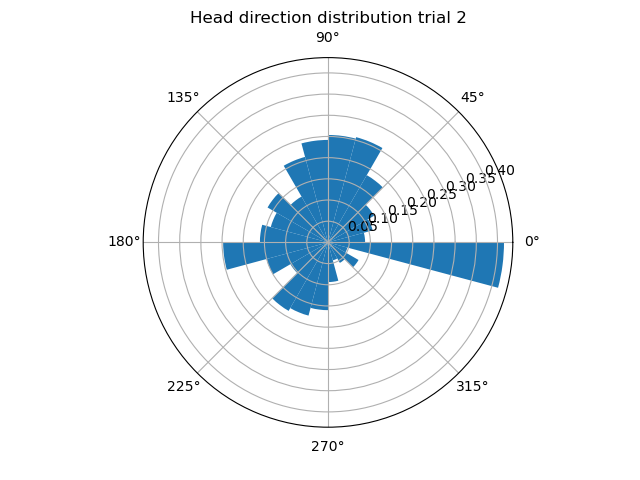

In [9]:
hd_rad = np.deg2rad(hd_new)

# Plot histogram
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
n, bins, _ = ax.hist(hd_rad, bins=24, density=True)  # or bins=36 for 10° bins
ax.set_title(f"Head direction distribution trial {tr}")
plt.show()

output_folder = os.path.join(behav_data_path, "hd_distribution")
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
output_path = os.path.join(output_folder, f"hd_distribution_t{tr}.png")


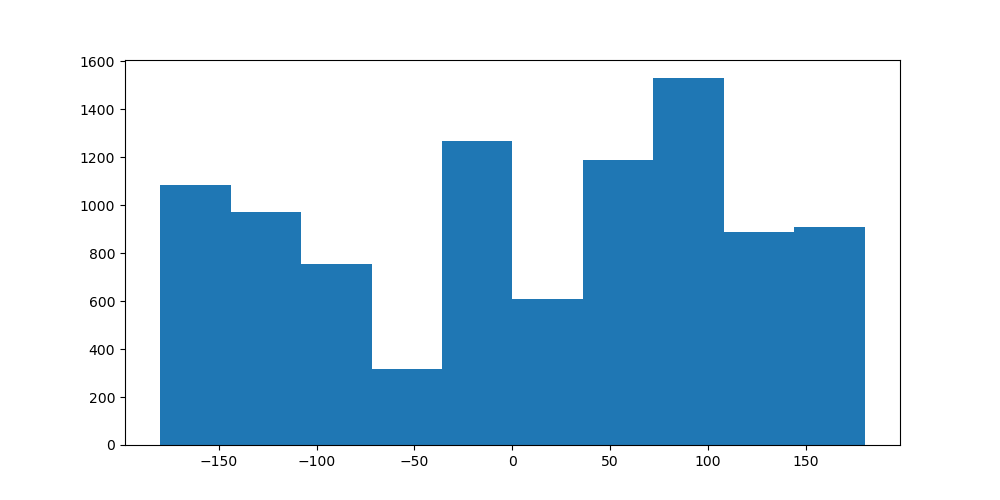

In [10]:
fig, ax = plt.subplots(figsize = [10,5])
plt.hist(hd_new)
plt.show()

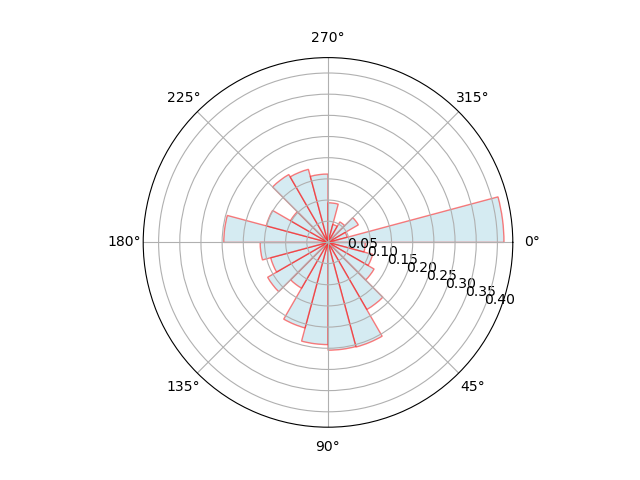

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# assume hd_new is in degrees
hd_rad = np.deg2rad(hd_new)
n_bins = 24  # 360° / 20° = 18 bins
bin_edges = np.linspace(0, 2*np.pi, n_bins + 1)

# Histogram (density=True makes it a probability density)
counts, _ = np.histogram(hd_rad % (2*np.pi), bins=bin_edges, density=True)

# Bin centers
theta = (bin_edges[:-1] + bin_edges[1:]) / 2
width = 2 * np.pi / n_bins

# Plot
fig = plt.figure()
ax = plt.subplot(111, polar=True)
ax.bar(theta, counts, width=width, facecolor='lightblue', edgecolor='red', alpha=0.5, align='center')
ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))  # 0° to 315°
ax.set_theta_direction(-1)
ax.set_theta_offset(0)  # 0 at right
plt.show()


In [12]:
def plot_polar_histogram(da, bin_width_deg=15, ax=None):
    """Plot a polar histogram of the data in the given DataArray.

    Parameters
    ----------
    da : xarray.DataArray
        A DataArray containing angle data in radians.
    bin_width_deg : int, optional
        Width of the bins in degrees.
    ax : matplotlib.axes.Axes, optional
        The axes on which to plot the histogram.

    """
    n_bins = int(360 / bin_width_deg)

    if ax is None:
        fig, ax = plt.subplots(  # initialise figure with polar projection
            1, 1, figsize=(5, 5), subplot_kw={"projection": "polar"}
        )
    else:
        fig = ax.figure  # or use the provided axes

    # plot histogram using xarray's built-in histogram function
    da.plot.hist(
        bins=np.linspace(-np.pi, np.pi, n_bins + 1), ax=ax, density=True
    )

    # axes settings
    ax.set_theta_direction(-1)  # theta increases in clockwise direction
    ax.set_theta_offset(0)  # set zero at the right
    ax.set_xlabel("")  # remove default x-label from xarray's plot.hist()

    # set xticks to match the phi values in degrees
    n_xtick_edges = 9
    ax.set_xticks(np.linspace(0, 2 * np.pi, n_xtick_edges)[:-1])
    xticks_in_deg = (
        list(range(0, 180 + 45, 45)) + list(range(0, -180, -45))[-1:0:-1]
    )
    ax.set_xticklabels([str(t) + "\N{DEGREE SIGN}" for t in xticks_in_deg])

    return fig, ax

(<Figure size 500x500 with 1 Axes>, <PolarAxes: >)

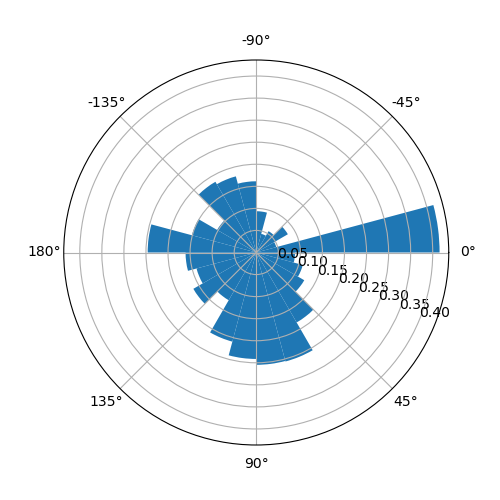

In [13]:
hd_rad = np.deg2rad(hd_new)
hd_xarray = xr.DataArray(hd_rad)
plot_polar_histogram(hd_xarray)


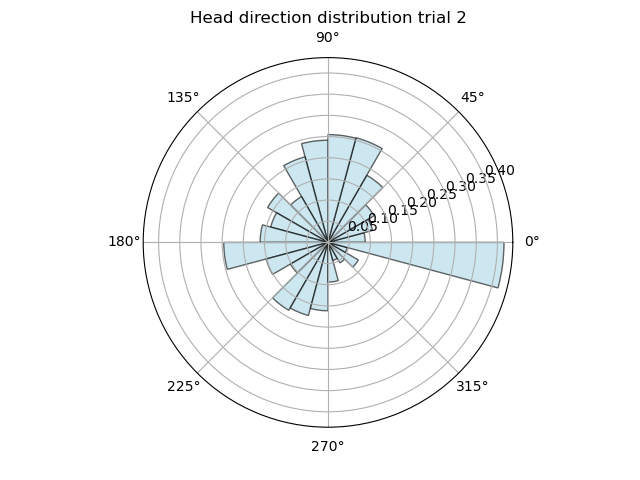

In [14]:
# Force bin range and centers to match histogram
n_bins = 24
bin_edges = np.linspace(0, 2*np.pi, n_bins + 1)
hd_rad_wrapped = hd_rad % (2*np.pi)
counts, _ = np.histogram(hd_rad_wrapped, bins=bin_edges, density=True)
theta = (bin_edges[:-1] + bin_edges[1:]) / 2
width = 2*np.pi / n_bins

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.bar(theta, counts, width=width, align='center', facecolor='lightblue', edgecolor='black', alpha=0.6)
ax.set_title(f"Head direction distribution trial {tr}")
plt.show()


In [15]:

def plot_polar_histogram(arr, bin_width_deg=15, ax=None):
    """
    Plot a polar histogram (rose plot) of angle data in radians.

    Parameters
    ----------
    arr : array-like
        Array of angles in radians.
    bin_width_deg : int, optional
        Width of histogram bins in degrees (default is 15).
    ax : matplotlib.axes._subplots.PolarAxesSubplot, optional
        Axes on which to plot. If None, creates a new one.
    """
    arr = np.asarray(arr)
    arr = arr[~np.isnan(arr)]  # Remove NaNs

    n_bins = int(360 / bin_width_deg)
    bins = np.linspace(-np.pi, np.pi, n_bins + 1)

    # Compute histogram
    counts, bin_edges = np.histogram(arr, bins=bins, density=True)

    # Compute bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Create polar axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "polar"})
    else:
        fig = ax.figure

    # Plot histogram as a bar plot on polar axes
    bars = ax.bar(bin_centers, counts, width=np.diff(bin_edges), align='center', edgecolor='k')

    # Format the plot
    ax.set_theta_direction(-1)
    ax.set_theta_offset(0)
    ax.set_xlabel("")

    # Set xticks
    n_xtick_edges = 9
    ax.set_xticks(np.linspace(0, 2 * np.pi, n_xtick_edges)[:-1])
    xticks_in_deg = (
        list(range(0, 180 + 45, 45)) + list(range(0, -180, -45))[-1:0:-1]
    )
    ax.set_xticklabels([str(t) + "\N{DEGREE SIGN}" for t in xticks_in_deg])

    return ax


In [16]:
!jupyter nbconvert --to script adjust_hd.ipynb

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate qtconsole run script
troubleshoot

Jupyter command `jupyter-nbconvert` not found.
